# Section 4.1.4. Normalizing Flow

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from utils import *

np.random.seed(0)
torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# -------------------------------
# Define the Normalizing Flow Model
# -------------------------------
class AffineCoupling(nn.Module):
    """
    Affine Coupling Layer as introduced in RealNVP.
    """
    def __init__(self, input_dim, hidden_dim, mask):
        super(AffineCoupling, self).__init__()
        self.mask = mask
        self.scale_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Tanh()  # constrain the scale to [-1, 1]
        )
        self.translate_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        x_masked = x * self.mask
        s = self.scale_net(x_masked) * (1 - self.mask)
        t = self.translate_net(x_masked) * (1 - self.mask)
        y = x_masked + (1 - self.mask) * (x * torch.exp(s) + t)
        log_det_jacobian = torch.sum(s, dim=1)
        return y, log_det_jacobian

    def inverse(self, y):
        y_masked = y * self.mask
        s = self.scale_net(y_masked) * (1 - self.mask)
        t = self.translate_net(y_masked) * (1 - self.mask)
        x = y_masked + (1 - self.mask) * ((y - t) * torch.exp(-s))
        log_det_jacobian = -torch.sum(s, dim=1)
        return x, log_det_jacobian

class NormalizingFlow(nn.Module):
    """
    Normalizing Flow model with multiple Affine Coupling layers.
    """
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(NormalizingFlow, self).__init__()
        self.layers = nn.ModuleList()
        mask = self.create_mask(input_dim, even=True)
        for i in range(num_layers):
            self.layers.append(AffineCoupling(input_dim, hidden_dim, mask))
            # Toggle the mask for the next layer
            mask = 1 - mask
        # Base distribution: standard normal
        self.base_mean = torch.zeros(input_dim).to(device)
        self.base_log_std = torch.zeros(input_dim).to(device)

    def create_mask(self, input_dim, even=True):
        """
        Create a mask tensor for the Affine Coupling layer.
        """
        mask = torch.zeros(input_dim)
        mask[::2] = 1 if even else 0
        mask[1::2] = 0 if even else 1
        return mask.to(device)

    def forward(self, x):
        """
        Forward pass through the Normalizing Flow model.
        """
        log_det_jacobian = torch.zeros(x.size(0)).to(device)
        for layer in self.layers:
            x, ldj = layer(x)
            log_det_jacobian += ldj
        log_prob_z = self.base_log_prob(x)
        log_prob = log_prob_z + log_det_jacobian
        return log_prob

    def inverse(self, z):
        """
        Inverse pass through the Normalizing Flow model.
        """
        for layer in reversed(self.layers):
            z, _ = layer.inverse(z)
        return z

    def base_log_prob(self, z):
        """
        Compute the log probability of the base distribution (standard normal).
        """
        log_std = self.base_log_std
        mean = self.base_mean
        return -0.5 * (((z - mean) / torch.exp(log_std)) ** 2 + 2 * log_std + np.log(2 * np.pi)).sum(1)

## 1. Training Stage

In [3]:
# -------------------------------
# Loss function
# -------------------------------
def compute_nf_loss(model, x):
    log_prob = model(x)
    loss = -torch.mean(log_prob)
    return loss

# -------------------------------
# Training
# -------------------------------
def train_nf(model, dataloader, optimizer, epochs, device):
    model.train()
    for epoch in range(1, epochs + 1):
        epoch_loss = 0.0
        for batch in dataloader:
            x = batch[0].to(device)
            optimizer.zero_grad()
            loss = compute_nf_loss(model, x)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * x.size(0)
        epoch_loss /= len(dataloader.dataset)
        if epoch % 2 == 0 or epoch == 1:
            print(f"Epoch [{epoch}/{epochs}], Loss: {epoch_loss:.4f}")

In [4]:
filepath = '../dataset/hts_example.csv'
hidden_dim = 128
num_layers = 6       # Num of Affine Coupling layer
learning_rate = 1e-3
batch_size = 512
epochs = 30

ground_truth_df, data_tensor, num_categories = load_and_preprocess_data(filepath, device)

dataset = torch.utils.data.TensorDataset(data_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

input_dim = data_tensor.shape[1]

# Normalizing Flow Model
flow_model = NormalizingFlow(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers).to(device)
optimizer = optim.Adam(flow_model.parameters(), lr=learning_rate)

# Training
train_nf(flow_model, dataloader, optimizer, epochs, device)

Column 'start_type' has 5 unique categories.
Column 'act_num' has 9 unique categories.
Column 'mode_num' has 9 unique categories.
Column 'end_type' has 5 unique categories.
Epoch [1/30], Loss: 4.9370
Epoch [2/30], Loss: 4.1751
Epoch [4/30], Loss: 3.9961
Epoch [6/30], Loss: 3.9175
Epoch [8/30], Loss: 3.8697
Epoch [10/30], Loss: 3.8521
Epoch [12/30], Loss: 3.8020
Epoch [14/30], Loss: 3.8071
Epoch [16/30], Loss: 3.7700
Epoch [18/30], Loss: 3.7512
Epoch [20/30], Loss: 3.7484
Epoch [22/30], Loss: 3.7382
Epoch [24/30], Loss: 3.7273
Epoch [26/30], Loss: 3.7205
Epoch [28/30], Loss: 3.7019
Epoch [30/30], Loss: 3.6961


## 2. Testing Stage

In [5]:
def generate_nf_samples(model, num_samples, sample_dim, device, columns, num_categories):
    """
    Use the trained Normalizing Flow model's inverse function to generate samples
    """
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, sample_dim).to(device)
        samples = model.inverse(z).cpu().numpy()
    generated_df = pd.DataFrame(samples, columns=columns)
    for column in columns:
        max_cat = num_categories[column] - 1
        generated_df[column] = np.floor(generated_df[column]).astype(int)
        generated_df[column] = np.clip(generated_df[column], 0, max_cat)
    return generated_df

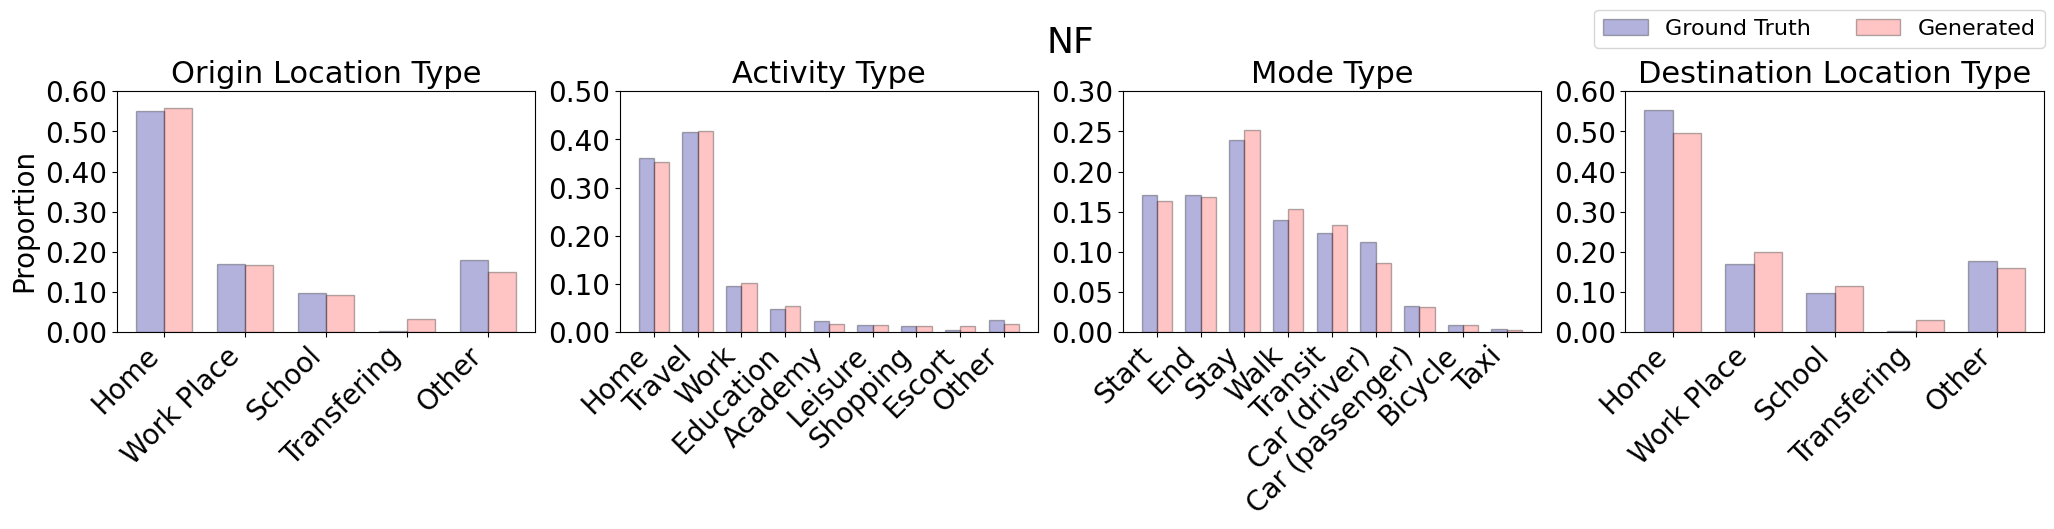

In [6]:
model_name = 'NF'
flow_model.eval()
num_samples = 3000

# Generate sampless
columns = ['start_type', 'act_num', 'mode_num', 'end_type']
generated_df = generate_nf_samples(flow_model, num_samples, sample_dim=len(columns), device=device,
                                    columns=columns, num_categories=num_categories)

xtick_labels_list = [
    ['Home', 'Work Place', 'School', 'Transfering', 'Other'],  # Start Location Type
    ['Home', 'Travel', 'Work', 'Education', 'Academy', 'Leisure', 'Shopping', 'Escort', 'Other'],  # Activity Type
    ['Start', 'End', 'Stay', 'Walk', 'Transit', 'Car (driver)', 'Car (passenger)', 'Bicycle', 'Taxi'],  # Mode Type
    ['Home', 'Work Place', 'School', 'Transfering', 'Other']  # End Location Type
]

visualize_results(model_name, ground_truth_df, generated_df, columns, xtick_labels_list)